2023-11-16 17:33:22.615554: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


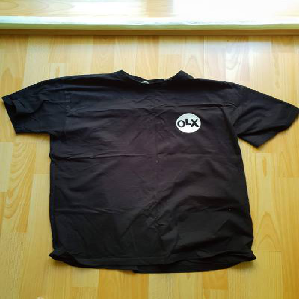

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
img = load_img(f'{path}/{name}',target_size=(299, 299))
img

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
x = np.array(img)
x.shape

X = np.array([x])

In [3]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [4]:
model = Xception(weights='imagenet', input_shape=(299,299,3))
result = model.predict(preprocess_input(X))
decode_predictions(result)

2023-11-16 17:33:31.209590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-16 17:33:31.223114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-16 17:33:31.223370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-16 17:33:31.223979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

1/1 [==============================] - 3s 3s/step


[[('n03595614', 'jersey', 0.6792451),
  ('n02916936', 'bulletproof_vest', 0.03960026),
  ('n04370456', 'sweatshirt', 0.035299566),
  ('n03710637', 'maillot', 0.010884127),
  ('n04525038', 'velvet', 0.0018057587)]]

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train', target_size=(150,150), batch_size=32)
type(train_ds)
train_ds.class_indices

Found 3068 images belonging to 10 classes.


{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [15]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation', target_size=(150,150), batch_size=32)
val_ds.class_indices

Found 341 images belonging to 10 classes.


{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [7]:
X, y = next(train_ds)
X.shape

(32, 150, 150, 3)

In [8]:
y.shape

(32, 10)

In [9]:
base_model = Xception(weights='imagenet', input_shape=(150,150,3), include_top=False)

base_model.trainable=False

In [10]:
#create new top/dense layers
input = keras.Input(shape=(150,150,3))
base = base_model(input)

pooling = keras.layers.GlobalAveragePooling2D()
vectors = pooling(base)

output = keras.layers.Dense(10)(vectors)

model= keras.Model(input, output)



In [11]:
preds = model.predict(X)



1/1 [==============================] - 1s 1s/step


In [12]:
#train the model
#need optimizers
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [13]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [16]:
history = model.fit(train_ds, epochs=2,validation_data=val_ds)

Epoch 1/2
96/96 [==============================] - 17s 159ms/step - loss: 1.3201 - accuracy: 0.6662 - val_loss: 0.8202 - val_accuracy: 0.7742
Epoch 2/2
96/96 [==============================] - 11s 117ms/step - loss: 0.5534 - accuracy: 0.8325 - val_loss: 0.7443 - val_accuracy: 0.8123


In [17]:
history.history

{'loss': [1.3201098442077637, 0.5533751845359802],
 'accuracy': [0.6662320494651794, 0.8324641585350037],
 'val_loss': [0.8201545476913452, 0.7442886233329773],
 'val_accuracy': [0.774193525314331, 0.8123167157173157]}

In [18]:
def make_model(lr = 0.01):
    base_model = Xception(weights='imagenet', input_shape=(150,150,3), include_top=False)
    base_model.trainable=False
    input = keras.Input(shape=(150,150,3))
    base = base_model(input)
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    output = keras.layers.Dense(10)(vectors)
    model= keras.Model(input, output)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model



In [35]:
scores = {}
for r in [0.0001, 0.001, 0.01, 0.1]:
    m = make_model(lr=r)
    history = m.fit(train_ds, epochs=10,validation_data=val_ds)
    scores[r]= history.history
    
    
    

Epoch 1/10
96/96 [==============================] - 13s 117ms/step - loss: 1.2570 - accuracy: 0.6695 - val_loss: 0.9341 - val_accuracy: 0.7390
Epoch 2/10
96/96 [==============================] - 11s 110ms/step - loss: 0.5168 - accuracy: 0.8237 - val_loss: 0.8413 - val_accuracy: 0.7889
Epoch 3/10
96/96 [==============================] - 10s 108ms/step - loss: 0.3329 - accuracy: 0.8882 - val_loss: 0.8703 - val_accuracy: 0.7918
Epoch 4/10
96/96 [==============================] - 10s 109ms/step - loss: 0.2265 - accuracy: 0.9195 - val_loss: 0.7634 - val_accuracy: 0.8211
Epoch 5/10
96/96 [==============================] - 10s 109ms/step - loss: 0.1330 - accuracy: 0.9524 - val_loss: 1.0058 - val_accuracy: 0.7742
Epoch 6/10
96/96 [==============================] - 11s 110ms/step - loss: 0.1145 - accuracy: 0.9570 - val_loss: 0.9091 - val_accuracy: 0.7977
Epoch 7/10
96/96 [==============================] - 10s 108ms/step - loss: 0.0610 - accuracy: 0.9821 - val_loss: 0.8977 - val_accuracy: 0.8065

In [50]:
type(scores)

dict

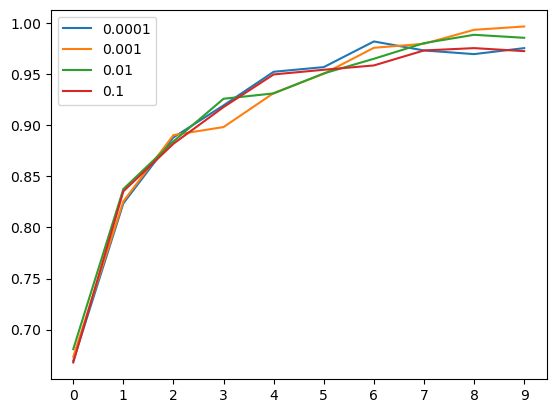

In [38]:
for r,history in scores.items():
    plt.plot(history['accuracy'], label=r)

plt.xticks(np.arange(10))
plt.legend()
    

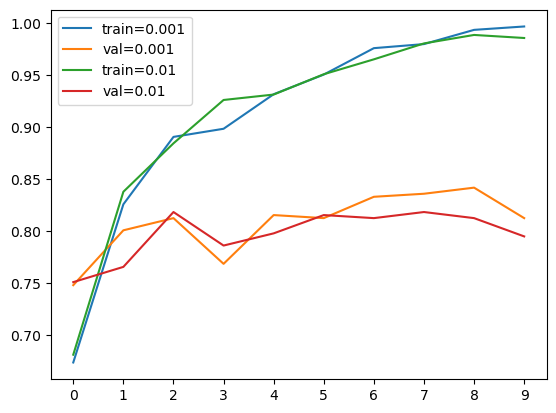

In [43]:
del scores[0.0001]
del scores[0.1]
for r,history in scores.items():
    plt.plot(history['accuracy'], label=('train=%s' % r))
    plt.plot(history['val_accuracy'], label=('val=%s' % r))

plt.xticks(np.arange(10))
plt.legend()

In [44]:
learning_rate = 0.001


In [51]:
checkpoint_callback = keras.callbacks.ModelCheckpoint('xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
                               save_best_only=True,
                               monitor='val_accuracy',
                               mode='max')




In [52]:
m = make_model(lr=learning_rate)
history = m.fit(train_ds, epochs=10,validation_data=val_ds, callbacks=[checkpoint_callback])

Epoch 1/10
96/96 [==============================] - 14s 128ms/step - loss: 1.0718 - accuracy: 0.6431 - val_loss: 0.7191 - val_accuracy: 0.7654
Epoch 2/10
96/96 [==============================] - 11s 119ms/step - loss: 0.6387 - accuracy: 0.7780 - val_loss: 0.6780 - val_accuracy: 0.7771
Epoch 3/10
96/96 [==============================] - 12s 123ms/step - loss: 0.5092 - accuracy: 0.8334 - val_loss: 0.5818 - val_accuracy: 0.8123
Epoch 4/10
96/96 [==============================] - 11s 116ms/step - loss: 0.4337 - accuracy: 0.8667 - val_loss: 0.5741 - val_accuracy: 0.8006
Epoch 5/10
96/96 [==============================] - 11s 117ms/step - loss: 0.3763 - accuracy: 0.8843 - val_loss: 0.5540 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 11s 117ms/step - loss: 0.3384 - accuracy: 0.8970 - val_loss: 0.5542 - val_accuracy: 0.8035
Epoch 7/10
96/96 [==============================] - 11s 117ms/step - loss: 0.2921 - accuracy: 0.9228 - val_loss: 0.5479 - val_accuracy: 0.8123

In [52]:
m = make_model(lr=learning_rate)
history = m.fit(train_ds, epochs=10,validation_data=val_ds, callbacks=[checkpoint_callback])

Epoch 1/10
96/96 [==============================] - 14s 128ms/step - loss: 1.0718 - accuracy: 0.6431 - val_loss: 0.7191 - val_accuracy: 0.7654
Epoch 2/10
96/96 [==============================] - 11s 119ms/step - loss: 0.6387 - accuracy: 0.7780 - val_loss: 0.6780 - val_accuracy: 0.7771
Epoch 3/10
96/96 [==============================] - 12s 123ms/step - loss: 0.5092 - accuracy: 0.8334 - val_loss: 0.5818 - val_accuracy: 0.8123
Epoch 4/10
96/96 [==============================] - 11s 116ms/step - loss: 0.4337 - accuracy: 0.8667 - val_loss: 0.5741 - val_accuracy: 0.8006
Epoch 5/10
96/96 [==============================] - 11s 117ms/step - loss: 0.3763 - accuracy: 0.8843 - val_loss: 0.5540 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 11s 117ms/step - loss: 0.3384 - accuracy: 0.8970 - val_loss: 0.5542 - val_accuracy: 0.8035
Epoch 7/10
96/96 [==============================] - 11s 117ms/step - loss: 0.2921 - accuracy: 0.9228 - val_loss: 0.5479 - val_accuracy: 0.8123

In [19]:
learning_rate = 0.001
def make_model(lr = learning_rate, size=100):
    base_model = Xception(weights='imagenet', input_shape=(150,150,3), include_top=False)
    base_model.trainable=False
    input = keras.Input(shape=(150,150,3))
    base = base_model(input)
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    innner = keras.layers.Dense(size, activation='relu')(vectors)
    output = keras.layers.Dense(10)(innner)
    model= keras.Model(input, output)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [59]:
scores = {}
for s in [10,100]:
    m = make_model(lr=learning_rate, size=s)
    history = m.fit(train_ds, epochs=10,validation_data=val_ds)
    scores[s]= history.history
    
    

Epoch 1/10
96/96 [==============================] - 13s 117ms/step - loss: 1.8613 - accuracy: 0.3690 - val_loss: 1.4130 - val_accuracy: 0.5806
Epoch 2/10
96/96 [==============================] - 10s 108ms/step - loss: 1.1035 - accuracy: 0.6672 - val_loss: 0.9293 - val_accuracy: 0.7214
Epoch 3/10
96/96 [==============================] - 11s 110ms/step - loss: 0.7824 - accuracy: 0.7510 - val_loss: 0.7691 - val_accuracy: 0.7507
Epoch 4/10
96/96 [==============================] - 11s 110ms/step - loss: 0.6332 - accuracy: 0.7950 - val_loss: 0.6892 - val_accuracy: 0.7713
Epoch 5/10
96/96 [==============================] - 10s 109ms/step - loss: 0.5289 - accuracy: 0.8377 - val_loss: 0.6726 - val_accuracy: 0.7595
Epoch 6/10
96/96 [==============================] - 10s 109ms/step - loss: 0.4686 - accuracy: 0.8475 - val_loss: 0.6488 - val_accuracy: 0.7830
Epoch 7/10
96/96 [==============================] - 11s 109ms/step - loss: 0.4119 - accuracy: 0.8722 - val_loss: 0.5975 - val_accuracy: 0.7889

In [20]:

for size,history in scores.items():
    plt.plot(history['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.legend()

NameError: name 'scores' is not defined

In [35]:
learning_rate = 0.0005
dense_layer_size = 100
shape = 299
def make_model(lr = learning_rate, size=dense_layer_size, shape=shape):
    base_model = Xception(weights='imagenet', input_shape=(shape,shape,3), include_top=False)
    base_model.trainable=False
    input = keras.Input(shape=(shape,shape,3))
    base = base_model(input)
    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)
    inner = keras.layers.Dense(size, activation='relu')(vectors)
    drop = keras.layers.Dropout(0.5)(inner)
    output = keras.layers.Dense(10)(drop)
    model= keras.Model(input, output)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               shear_range=10,
                               zoom_range=0.1
                              )
train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train', target_size=(shape,shape), batch_size=32)


Found 3068 images belonging to 10 classes.


In [37]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               shear_range=10,
                               zoom_range=0.1
                              )
val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation', target_size=(shape,shape), batch_size=32)


Found 341 images belonging to 10 classes.


In [38]:
checkpoint_callback = keras.callbacks.ModelCheckpoint('xception_v4_{epoch:02d}_{val_accuracy:.3f}.h5',
                               save_best_only=True,
                               monitor='val_accuracy',
                               mode='max')

In [39]:
m = make_model(lr=learning_rate,size=dense_layer_size,shape=shape)
history = m.fit(train_ds, epochs=50,validation_data=val_ds, callbacks=[checkpoint_callback])

Epoch 1/50
96/96 [==============================] - 66s 658ms/step - loss: 1.2216 - accuracy: 0.6229 - val_loss: 0.6796 - val_accuracy: 0.7918
Epoch 2/50
96/96 [==============================] - 61s 633ms/step - loss: 0.6813 - accuracy: 0.7819 - val_loss: 0.5151 - val_accuracy: 0.8387
Epoch 3/50
96/96 [==============================] - 61s 635ms/step - loss: 0.5769 - accuracy: 0.8077 - val_loss: 0.4592 - val_accuracy: 0.8504
Epoch 4/50
96/96 [==============================] - 61s 632ms/step - loss: 0.5023 - accuracy: 0.8328 - val_loss: 0.3995 - val_accuracy: 0.8651
Epoch 5/50
96/96 [==============================] - 60s 621ms/step - loss: 0.4603 - accuracy: 0.8494 - val_loss: 0.4336 - val_accuracy: 0.8651
Epoch 6/50
96/96 [==============================] - 60s 621ms/step - loss: 0.4221 - accuracy: 0.8608 - val_loss: 0.3939 - val_accuracy: 0.8622
Epoch 7/50
96/96 [==============================] - 60s 628ms/step - loss: 0.4044 - accuracy: 0.8628 - val_loss: 0.3999 - val_accuracy: 0.8680

KeyboardInterrupt: 

In [45]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_ds = test_gen.flow_from_directory('./clothing-dataset-small/test', target_size=(shape,shape), batch_size=32)


Found 372 images belonging to 10 classes.


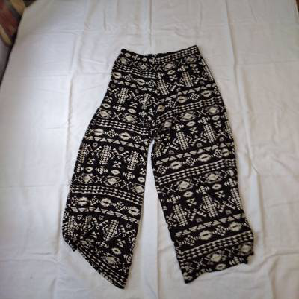

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
pants = '01033304-f9a4-48c4-af65-677512880fae.jpg'
path = './clothing-dataset-small/test/pants'
img  = load_img(f'{path}/{pants}', target_size=(shape,shape))
img



In [53]:
x= np.array(img)
X = preprocess_input(np.array([x]))

In [57]:
mo = keras.models.load_model('xception_v4_08_0.871.h5')
mo.evaluate(test_ds)

12/12 [==============================] - 3s 199ms/step - loss: 0.2932 - accuracy: 0.9032


[0.29318946599960327, 0.9032257795333862]

In [69]:
pred = mo.predict(X)
classes = list(test_ds.class_indices.keys())
dict(zip(classes,pred[0]))


1/1 [==============================] - 0s 20ms/step


{'dress': -1.4064866,
 'hat': -3.3805032,
 'longsleeve': -1.0845397,
 'outwear': -1.1528735,
 'pants': 8.156036,
 'shirt': -1.1351745,
 'shoes': -3.987476,
 'shorts': 3.2837293,
 'skirt': -2.118874,
 't-shirt': -3.0030112}

In [77]:
def convert(image_path):
    img  = load_img(image_path, target_size=(shape,shape))
    x = np.array(img)
    X = preprocess_input(np.array([x]))
    return X

In [81]:
def print_pred(pred):
    classes = list(test_ds.class_indices.keys())
    return dict(zip(classes,pred[0]))

In [82]:
item = '2001dec1-1e0a-4c11-9d15-120b019b3dea.jpg'
path = './clothing-dataset-small/test/skirt'
image_path= f'{path}/{item}'
image_path
X = convert(image_path)

pred = mo.predict(X)
print_pred(pred)

1/1 [==============================] - 0s 20ms/step


{'dress': 0.42439198,
 'hat': -2.2150817,
 'longsleeve': -2.6224678,
 'outwear': -2.8824966,
 'pants': 0.9254929,
 'shirt': -2.955814,
 'shoes': -2.6900053,
 'shorts': 2.6305652,
 'skirt': 6.487536,
 't-shirt': -1.3242892}